In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from pprint import pprint
from fake_useragent import UserAgent
from sklearn.preprocessing import StandardScaler
from pyopt.client import PriceHistory
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

/var/folders/sp/kv_nm1x15xs4v4444j_8fyyh0000gn/T/ipykernel_6606/4244552276.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
# Defining Stocks
portfolio = ['AAPL', 'AMZN', 'MA', 'TXRH', 'CRM', 'MCO', 'VICI', 'XOM', 'MO']
watchlist = ['GOOG', 'MSFT', 'V', 'WM', 'PLTR' 'SCHG', 'SCHD', 'VOO', 'GLD']
test_user1 = ['MA', 'META', 'AMZN', 'LOW', 'COST', 'WM', 'CRM', 'MKC', 'CL', 'NFLX', 'XOM', 'JNJ', 'PEP', 'HSY', 'O', 'AXP', 'AVGO', 'GOOG', 'WMT', 'AAPL', 'V', 'MSFT', 'JPM', 'MO', 'VICI']

# Number of stocks in the Portfolio
num_stocks_portfolio = len(portfolio)

if not pathlib.Path(r'/Users/harnishsavadia/Desktop/Capstone Project/data/stock_data.csv').exists():
    user_agent = UserAgent(fallback="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3")
    price_history_client = PriceHistory(symbols= portfolio, user_agent=user_agent)
    price_history_client.price_data_frame.to_csv(
        r'/Users/harnishsavadia/Desktop/Capstone Project/data/stock_data.csv',
        index=False,
    )
    # display(price_history_client.price_data_frame)

    price_data_frame: pd.DataFrame = price_history_client.price_data_frame

else: 
    price_data_frame: pd.DataFrame = pd.read_csv(r'/Users/harnishsavadia/Desktop/Capstone Project/data/stock_data.csv')

display(price_data_frame)

API Response for AAPL: {'data': {'symbol': 'AAPL', 'totalRecords': 250, 'tradesTable': {'asOf': None, 'headers': {'date': 'Date', 'close': 'Close/Last', 'volume': 'Volume', 'open': 'Open', 'high': 'High', 'low': 'Low'}, 'rows': [{'date': '11/08/2024', 'close': '$226.96', 'volume': '38,328,820', 'open': '$227.17', 'high': '$228.66', 'low': '$226.405'}, {'date': '11/07/2024', 'close': '$227.48', 'volume': '42,137,690', 'open': '$224.625', 'high': '$227.875', 'low': '$224.57'}, {'date': '11/06/2024', 'close': '$222.72', 'volume': '54,561,120', 'open': '$222.61', 'high': '$226.065', 'low': '$221.19'}, {'date': '11/05/2024', 'close': '$223.45', 'volume': '28,111,340', 'open': '$221.795', 'high': '$223.95', 'low': '$221.14'}, {'date': '11/04/2024', 'close': '$222.01', 'volume': '44,944,470', 'open': '$220.99', 'high': '$222.79', 'low': '$219.71'}, {'date': '11/01/2024', 'close': '$222.91', 'volume': '65,276,740', 'open': '$220.965', 'high': '$225.35', 'low': '$220.27'}, {'date': '10/31/2024'

,symbol,date,close,volume,open,high,low
0,AAPL,2024-11-08,226.96,38328820,227.170,228.660,226.405
1,AAPL,2024-11-07,227.48,42137690,224.625,227.875,224.570
2,AAPL,2024-11-06,222.72,54561120,222.610,226.065,221.190
3,AAPL,2024-11-05,223.45,28111340,221.795,223.950,221.140
4,AAPL,2024-11-04,222.01,44944470,220.990,222.790,219.710
...,...,...,...,...,...,...,...
2245,MO,2023-11-17,40.82,6660505,40.800,40.965,40.510
2246,MO,2023-11-16,40.70,10810030,40.700,40.945,40.130
2247,MO,2023-11-15,40.75,9460341,40.450,40.770,40.180
2248,MO,2023-11-14,40.22,12681150,40.230,40.420,39.960


In [3]:
# Grab columns we need
price_data_frame = price_data_frame[['date', 'symbol', 'close']]

# Pivot the Data Frame to make the symbols the headers
price_data_frame = price_data_frame.pivot(
    index='date',
    columns='symbol',
    values='close'
)

display(price_data_frame.head())

symbol,AAPL,AMZN,CRM,MA,MCO,MO,TXRH,VICI,XOM
date,,,,,,,,,
2023-11-13,184.80,142.59,215.28,394.35,343.51,40.00,107.29,28.09,104.84
2023-11-14,187.44,145.80,221.18,397.65,351.17,40.22,110.13,29.15,104.29
2023-11-15,188.01,143.20,219.42,396.83,350.70,40.75,110.39,28.90,103.66
2023-11-16,189.71,142.83,221.45,397.10,353.57,40.70,110.18,28.70,102.46
2023-11-17,189.69,145.18,221.22,400.30,356.67,40.82,110.78,28.58,104.96


In [4]:
# Calculate the expected log return
log_return = np.log(1 + price_data_frame.pct_change())

# Generate some random weights or use portfolio weights
random_weights = np.array(np.random.random(num_stocks_portfolio))
# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# OR you can use Portfolio's rebalanced weights
portfolio_weights = [0.0586, 0.0605, 0.0892, 0.2951, 0.0979, 0.0649, 0.0922, 0.2083, 0.0333] 
test_user1_weights = [0.0138, 0.0453, 0.0210, 0.0036, 0.0126, 0.1085, 0.0228, 0.0333, 0.0239, 0.02, 0.0176, 0.0335, 0.1530, 0.0357, 0.0103, 0.025, 0.0181, 0.0206, 0.0077, 0.0215, 0.0341, 0.0403, 0.0255, 0.0033, 0.0160] 




# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights Portfolio/Random': rebalance_weights
})
weights_df_styled = weights_df.style.set_properties(**{'text-align': 'center'})

print('')
print('PORTFOLIO WEIGHTS:')
print('='*80)
display(weights_df_styled)
print('')

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

metrics_df_styled = metrics_df.style.set_properties(**{'text-align': 'center'})
print('')
print('PORTFOLIO METRICS:')
print('='*80)
display(metrics_df_styled)


PORTFOLIO WEIGHTS:


,random_weights,rebalance_weights Portfolio/Random
0,0.351957,0.110393
1,0.055680,0.017464
2,0.547009,0.171572
3,0.475878,0.149261
4,0.976846,0.306392
5,0.233888,0.073360
6,0.017313,0.005430
7,0.380344,0.119297
8,0.149308,0.046831




PORTFOLIO METRICS:


,Expected Portfolio Returns,Expected Portfolio Volatility,Portfolio Sharpe Ratio
0,0.290564,0.135290,2.147706


In [5]:
# Number of times you run the simulation
num_of_simulations = 20000

# Building empty array of zeros for all weights 
weights_array = np.zeros((num_of_simulations, num_stocks_portfolio))

# Building empty array of zeros for all returns 
returns_array = np.zeros(num_of_simulations)

# Building empty array of zeros for all volatility
volatility_array = np.zeros(num_of_simulations)

# Building empty array of zeros for all sharpe ratio
sharpe_ratio_array = np.zeros(num_of_simulations)

# Start the simualtion
for index in range(num_of_simulations):
    
    # Calculate weights
    weights = np.random.random(num_stocks_portfolio)
    rebalance_weights = weights / np.sum(weights)

    # Adding to rebalanced weights to weights_array
    weights_array[index, :] = rebalance_weights

    # Calculating the expected returns in returns_array
    returns_array[index] = np.sum((log_return.mean() * rebalance_weights) * 252)

    # Calculating the expected volatility in volatility_array
    volatility_array[index] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, rebalance_weights))
    )

    # Calculating the sharpe ratio in sharpe_ratio_array
    sharpe_ratio_array[index] = ( returns_array[index] - .01 ) / volatility_array[index]

# Combining all together
simulations_data = [returns_array, volatility_array, sharpe_ratio_array, weights_array]

# Create a Dataframe from the simulations_data array
simulations_df = pd.DataFrame(simulations_data).T

# Add the column names
simulations_df.columns = ['Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio Weights']

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print results
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                                                                                                                               Portfolio Weights
0  0.339828  0.291456    1.131657      [0.014235140475119932, 0.1644148348328688, 0.1291668013240555, 0.05173514000607603, 0.11118198577241747, 0.16670647425914153, 0.1482421639769216, 0.13356428384063299, 0.08075317551276603]   
1  0.309512  0.241936    1.237979      [0.013997532093036766, 0.2320694400085803, 0.13202198135442322, 0.08910371958273237, 0.027858930853893807, 0.14706972734181628, 0.07026045498605984, 0.04075660876335613, 0.2468616050161014] 
2  0.316270  0.284651    1.075948      [0.16173555598433215, 0.0501096489618629, 0.14466610600387841, 0.03979454200886739, 0.1567243877036514, 0.11988541848035737, 0.13312300369270572, 0.189296443774589, 0.00

In [6]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.32783                                                                                                                                                                                      
Volatility           0.149249                                                                                                                                                                                     
Sharpe Ratio         2.129527                                                                                                                                                                                     
Portfolio Weights    [0.09315879687083846, 0.1564673376746362, 0.007665376890084592, 0.060855947660714185, 0.016089415761150205, 0.3221970857844226, 0.16473741169685735, 0.1122742990731903, 0.06655432858810616]
Name: 19074, dtype: object
-----------------------------

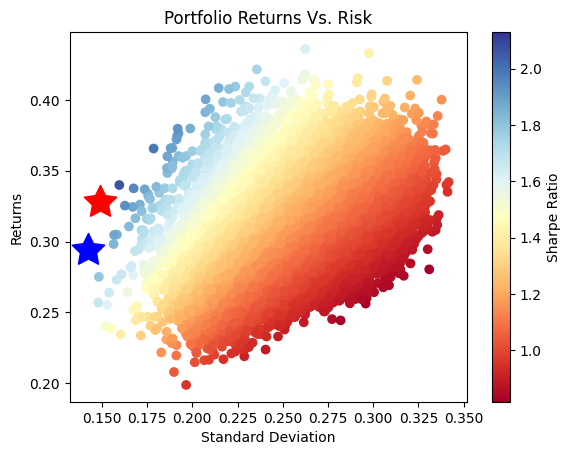

In [7]:
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Add labels
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

In [8]:
def get_metrics(weights: list) -> np.array:
    # Convert to a Numpy Array.
    weights = np.array(rebalance_weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol
    return np.array([ret, vol, sr])

def cal_negative_sharpe(weights: list) -> np.array:
    return get_metrics(weights)[2] - 1

def cal_volatility(weights: list) -> np.array:
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    return np.sum(weights) - 1

In [9]:
# Define the boundaries for each symbol. Remember I can only invest 
# up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(num_stocks_portfolio))

# Define the constraints, here I'm saying that the sum of each weight 
# must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = num_stocks_portfolio * [1 / num_stocks_portfolio]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    cal_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6473209752831628
       x: [ 1.111e-01  1.111e-01  1.111e-01  1.111e-01  1.111e-01
            1.111e-01  1.111e-01  1.111e-01  1.111e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 10
    njev: 1
--------------------------------------------------------------------------------


In [14]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)

# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('RETURNS | VOLATILITY | SHARPE RATIO:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
RETURNS | VOLATILITY | SHARPE RATIO:
--------------------------------------------------------------------------------
[0.36250825 0.136934   2.64732098]
--------------------------------------------------------------------------------


In [11]:
# Define the boundaries for each symbol. Remember I can only invest 
# up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(num_stocks_portfolio))

# Define the constraints, here I'm saying that the sum of each weight 
# must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = num_stocks_portfolio * [1 / num_stocks_portfolio]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    cal_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.13693400126826435
       x: [ 1.111e-01  1.111e-01  1.111e-01  1.111e-01  1.111e-01
            1.111e-01  1.111e-01  1.111e-01  1.111e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 10
    njev: 1
--------------------------------------------------------------------------------


In [12]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)

# optimized_metrics.columns = ['Returns', 'Volatility', 'Sharpe Ratio']
# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.36250825 0.136934   2.64732098]
--------------------------------------------------------------------------------
